<a href="https://colab.research.google.com/github/MicahSee/Interpretable-LSTM/blob/main/Interpretable_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

class TimeSeriesDataset(Dataset):
    def __init__(self, dataset, seq_len=1):
        self.dataset = dataset
        self.seq_len = seq_len

    def __len__(self):
        return self.dataset.__len__() - self.seq_len

    def __getitem__(self, index):
        return self.dataset[index:index+self.seq_len], self.dataset[index+self.seq_len]


class TSModel(nn.Module):
    def __init__(self, features, hidden_units=32, num_layers=2, dropout=0.2):
        super(TSModel, self).__init__()

        self.n_hidden = hidden_units
        self.lstm = nn.LSTM(
            input_size=features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout
        )
        self.linear = nn.Linear(hidden_units, features)

    def forward(self, x):
        # print('Input shape' + str(x.shape))
        _, (hidden, _) = self.lstm(x)
        # print('LSTM out shape' + str(hidden.shape))
        lstm_out = hidden[-1]  # output last hidden state output
        # print('Last hidden state shape' + str(lstm_out.shape))
        y_pred = self.linear(lstm_out)
        # print('Output shape' + str(y_pred.shape))

        return y_pred


def train_model(
        train_df,
        test_df,
        label_name,
        sequence_length,
        batch_size,
        n_epochs,
        n_epochs_stop,
        criterion
):
    """Train LSTM model."""
    print("Starting with model training...")

    # create dataloaders
    train_dataset = TimeSeriesDataset(np.array(train_df), seq_len=sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TimeSeriesDataset(np.array(test_df), seq_len=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # set up training
    n_features = train_df.shape[1]
    model = TSModel(n_features)
    model = model.to(device)
    # criterion = torch.nn.MSELoss()  # L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_hist = []
    test_hist = []

    # start training
    best_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(1, n_epochs+1):
        running_loss = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader, 1):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            data = torch.Tensor(np.array(data)).to(device)
            output = model(data)
            loss = criterion(output, target.type_as(output))
            # if type(criterion) == torch.nn.modules.loss.MSELoss:
            #     loss = torch.sqrt(loss)  # RMSE
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_loader)
        train_hist.append(running_loss)

        # test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = torch.Tensor(np.array(data)).to(device)
                output = model(data)
                loss = criterion(output, target.type_as(output))
                test_loss += loss.item()

            test_loss /= len(test_loader)
            test_hist.append(test_loss)

            # early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), 'model.pt')
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print("Early stopping.")
                break

        print(f'Epoch {epoch} train loss: {round(running_loss,4)} test loss: {round(test_loss,4)}')

        hist = pd.DataFrame()
        hist['training_loss'] = train_hist
        hist['test_loss'] = test_hist

    print("Training completed.")

    hist.plot(figsize=(12,6))
    plt.show()

    return model, hist

**Set global params**

In [ ]:
sequence_length = 30
num_features = 2

In [ ]:
inference_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import requests

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&datatype=csv&apikey=ZN0OVWTE2EQWLSVI'

r = requests.get(url)
with open('IBM_daily.csv', 'wb') as f:
    f.write(r.content)

In [ ]:
stock_df = pd.read_csv('IBM_daily.csv')

In [ ]:
stock_df

,timestamp,open,high,low,close,volume
0,2024-01-17,166.79,167.815,165.495,166.03,4286964
1,2024-01-16,165.80,167.250,165.340,166.96,4869635
2,2024-01-12,162.97,165.980,162.355,165.80,4958261
3,2024-01-11,161.02,162.230,160.290,162.16,3778395
4,2024-01-10,160.28,161.340,159.740,161.23,2967852
...,...,...,...,...,...,...
6086,1999-11-05,92.75,92.940,90.190,90.25,13737600
6087,1999-11-04,94.44,94.440,90.000,91.56,16697600
6088,1999-11-03,95.87,95.940,93.500,94.37,10369100
6089,1999-11-02,96.75,96.810,93.690,94.81,11105400


In [ ]:
from sklearn.preprocessing import StandardScaler

model_df = stock_df.drop(['timestamp', 'open', 'high', 'low'], axis=1)

feature_scaler = StandardScaler()
model_df[['close', 'volume']] = feature_scaler.fit_transform(model_df[['close', 'volume']])

In [ ]:
# Set time order from oldest to most recent
model_df = model_df[::-1].set_index(model_df.index)

In [ ]:
model_df.head()

,close,volume
0,-0.939780,1.088924
1,-0.994725,1.558948
2,-1.007187,1.336189
3,-1.086772,3.250806
4,-1.123874,2.355291


In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.2, shuffle=False)

In [ ]:
train_dataset = TimeSeriesDataset(np.array(train_df), seq_len=sequence_length)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

Starting with model training...
Epoch 1 train loss: 1.0092 test loss: 0.4137
Epoch 2 train loss: 0.5291 test loss: 0.458
Epoch 3 train loss: 0.4727 test loss: 0.4106
Epoch 4 train loss: 0.395 test loss: 0.3825
Epoch 5 train loss: 0.3679 test loss: 0.3796
Epoch 6 train loss: 0.3438 test loss: 0.368
Epoch 7 train loss: 0.3277 test loss: 0.3606
Epoch 8 train loss: 0.317 test loss: 0.3553
Epoch 9 train loss: 0.3086 test loss: 0.3521
Epoch 10 train loss: 0.3024 test loss: 0.3493
Epoch 11 train loss: 0.2989 test loss: 0.3462
Epoch 12 train loss: 0.2951 test loss: 0.3431
Epoch 13 train loss: 0.2915 test loss: 0.3396
Epoch 14 train loss: 0.2887 test loss: 0.3359
Epoch 15 train loss: 0.2853 test loss: 0.333
Epoch 16 train loss: 0.2803 test loss: 0.33
Epoch 17 train loss: 0.277 test loss: 0.3276
Epoch 18 train loss: 0.275 test loss: 0.325
Epoch 19 train loss: 0.2749 test loss: 0.3234
Epoch 20 train loss: 0.2714 test loss: 0.3217
Epoch 21 train loss: 0.2712 test loss: 0.3205
Epoch 22 train loss: 

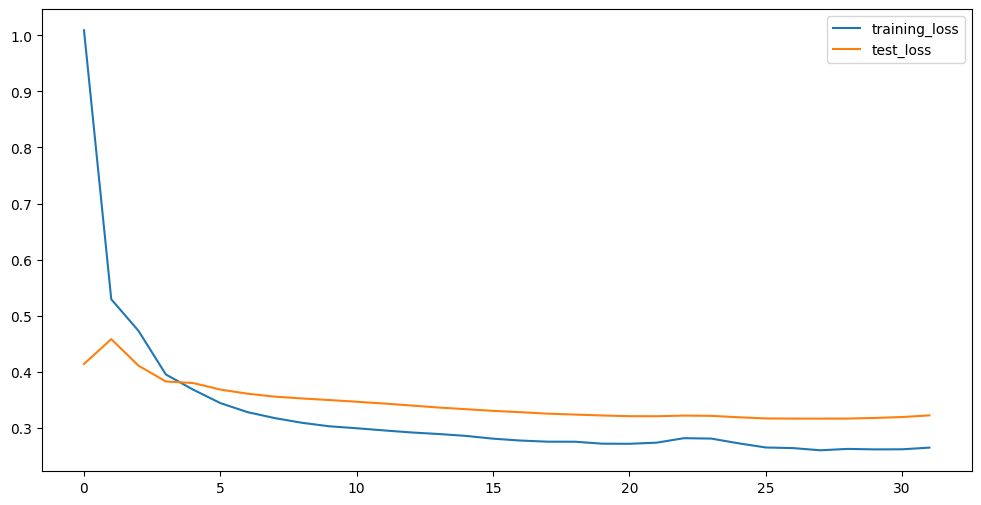

In [ ]:
model, hist = train_model(
    train_df=train_df,
    test_df=test_df,
    label_name='close',
    sequence_length=30,
    batch_size=100,
    n_epochs=200,
    n_epochs_stop=5,
    criterion=nn.MSELoss()
)

In [ ]:
def compute_comp_error(trunc_df):

  # Calculate the mean squared error.
  mse = np.mean((trunc_df['label_close'].values - trunc_df['pred_close'].values) ** 2)

  # Return the mean squared error.
  return mse

def predict(
        df,
        label_name,
        sequence_length,
        scaler
):
    """Make predictions."""

    model = TSModel(df.shape[1])
    model.load_state_dict(torch.load('model.pt'))
    model.eval()

    test_dataset = TimeSeriesDataset(np.array(df), seq_len=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    predictions = []
    # labels = []
    with torch.no_grad():
        for features, target in test_loader:
            features = torch.Tensor(np.array(features))
            output = model(features)
            predictions.append(output.numpy())
            # labels.append(target.numpy())

    predictions = np.vstack(predictions)
    # label = np.hstack(labels)

    # bring predictions back to original scale
    descaler = StandardScaler()
    descaler.mean_, descaler.scale_ = scaler.mean_, scaler.scale_
    predictions_descaled = descaler.inverse_transform(np.array(predictions))
    # labels_descaled = descaler.inverse_transform(np.array(labels))

    # return predictions_descaled, labels_descaled
    return predictions_descaled

def predict_after_ray(
  df,
  label_name,
  sequence_length,
  scaler,
  result_grid
):
  model = TSModel(df.shape[1], **result_grid.get_best_result().config)

  with result_grid.get_best_result().checkpoint.as_directory() as checkpoint_dir:
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "checkpoint.pt")))

  model.eval()

  test_dataset = TimeSeriesDataset(np.array(df), np.array(df[label_name]), seq_len=sequence_length)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

  predictions = []
  labels = []
  with torch.no_grad():
      for features, target in test_loader:
          features = torch.Tensor(np.array(features))
          output = model(features)
          predictions.append(output.item())
          labels.append(target.item())

  # bring predictions back to original scale
  descaler = StandardScaler()
  descaler.mean_, descaler.scale_ = scaler.mean_[-2], scaler.scale_[-2]
  predictions_descaled = descaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
  labels_descaled = descaler.inverse_transform(np.array(labels).reshape(-1, 1)).flatten()

  return predictions_descaled, labels_descaled

In [ ]:
test_df

,close,volume
4872,0.269008,0.363401
4873,0.291100,-0.812016
4874,0.299030,-0.747325
4875,0.273823,-0.696765
4876,0.325936,-0.710088
...,...,...
6086,0.886431,-0.902977
6087,0.912770,-0.657756
6088,1.015863,-0.300801
6089,1.048716,-0.327613


In [ ]:
predictions_descaled = predict(df=test_df,
                                label_name='close',
                                sequence_length=sequence_length,
                                scaler=feature_scaler)

In [ ]:
predictions_descaled

array([[1.4076797e+02, 3.4613318e+06],
       [1.3982245e+02, 3.4662262e+06],
       [1.3948540e+02, 4.2000715e+06],
       ...,
       [1.6126132e+02, 3.6287322e+06],
       [1.6259660e+02, 4.3407030e+06],
       [1.6434401e+02, 4.5389765e+06]], dtype=float32)

In [ ]:
def prep_data_for_plot(
        orig_df,
        inf_df,
        predictions,
):

  trunc_df = orig_df[::-1].set_index(orig_df.index).iloc[-(len(inf_df)-sequence_length):, :]
  trunc_df = trunc_df[['timestamp', 'close']]
  trunc_df[['timestamp', 'label_close']] = trunc_df[['timestamp', 'close']]
  trunc_df['pred_close'] = predictions_descaled[:, 0]
  trunc_df['timestamp'] = pd.to_datetime(trunc_df['timestamp'])
  trunc_df = trunc_df.drop(['close'], axis=1)
  return trunc_df

In [ ]:
data2 = prep_data_for_plot(orig_df=stock_df, inf_df=test_df, predictions=predictions_descaled)
data2

,timestamp,label_close,pred_close
4902,2019-04-29,139.05,140.767975
4903,2019-04-30,140.27,139.822449
4904,2019-05-01,140.56,139.485397
4905,2019-05-02,139.59,140.016418
4906,2019-05-03,140.25,140.422363
...,...,...,...
6086,2024-01-10,161.23,161.120972
6087,2024-01-11,162.16,160.926178
6088,2024-01-12,165.80,161.261322
6089,2024-01-16,166.96,162.596603


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_labels(
        pred_df,
        trial_name
):

  plt.plot(pred_df['timestamp'].values, pred_df['label_close'].values)
  plt.plot(pred_df['timestamp'].values, pred_df['pred_close'].values)

  plt.legend(['Actual', 'Predicted'])
  plt.title('IBM Stock Price Prediction' + ' (' + trial_name + ')')
  plt.xlabel('Date')
  plt.ylabel('Stock Price ($)')
  plt.show()

  return

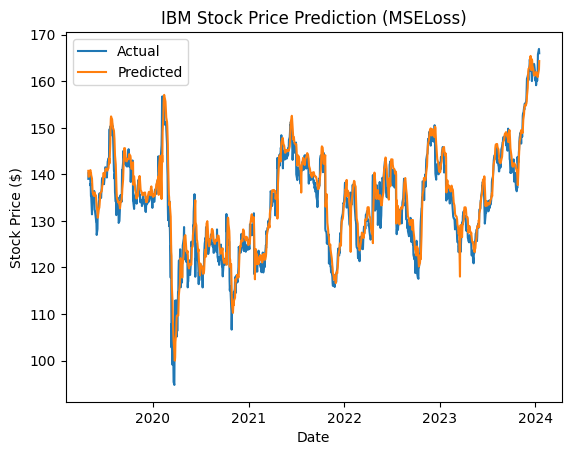

In [ ]:
data2 = prep_data_for_plot(orig_df=stock_df, inf_df=test_df, predictions=predictions_descaled)
plot_predictions_labels(pred_df=data2, trial_name='MSELoss')

In [ ]:
from captum.attr import IntegratedGradients

interpreter = IntegratedGradients(model)

In [ ]:
# train_dataset = TimeSeriesDataset(np.array(train_df), seq_len=sequence_length)
# train_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)

test_dataset = TimeSeriesDataset(np.array(test_df), seq_len=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

sample_data, _ = next(iter(test_loader))
sample_data = sample_data.type(torch.float32).to(device)

In [ ]:
model.train()
attributions = interpreter.attribute(sample_data, target=0)

In [ ]:
attr  = attributions.cpu().detach().numpy()

In [ ]:
attr.shape

(1000, 30, 2)

In [ ]:
def generate_attr_area_plot(attr, title):
  mean_attr = np.mean(attr, axis=0)
  mean_attr = np.abs(mean_attr)
  attr_plot = pd.DataFrame(mean_attr, columns=train_df.columns.tolist())
  attr_plot['days'] = [i-31 for i in list(range(1,31))]
  attr_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
  plt.title(title)
  plt.show()

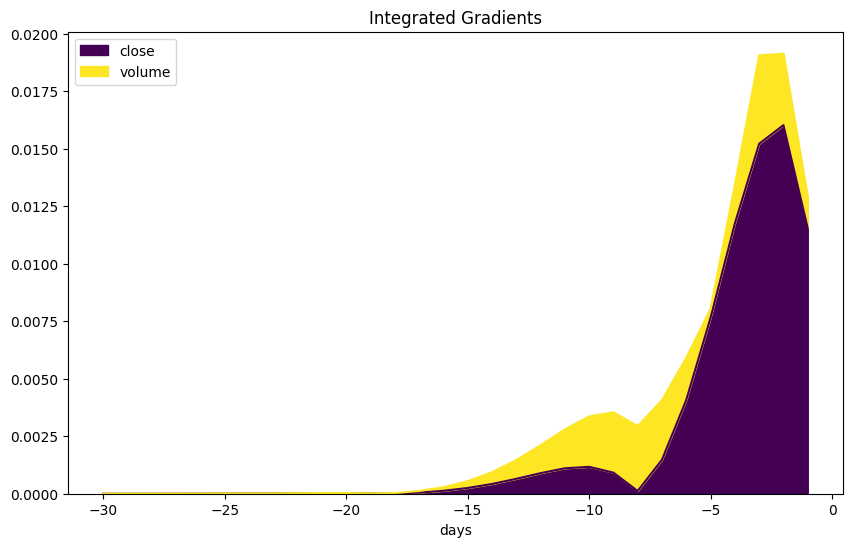

In [ ]:
generate_attr_area_plot(attr, 'Integrated Gradients')

In [ ]:
from captum.attr import DeepLift

# Create an instance of the DeepLift class
interpreter = DeepLift(model)

# Assuming 'input' is a tensor of shape (batch_size, input_size)
# Compute attributions using DeepLift
attributions = interpreter.attribute(sample_data, target=0)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
att  = attributions.cpu().detach().numpy()

In [ ]:
att.shape

(1000, 30, 2)

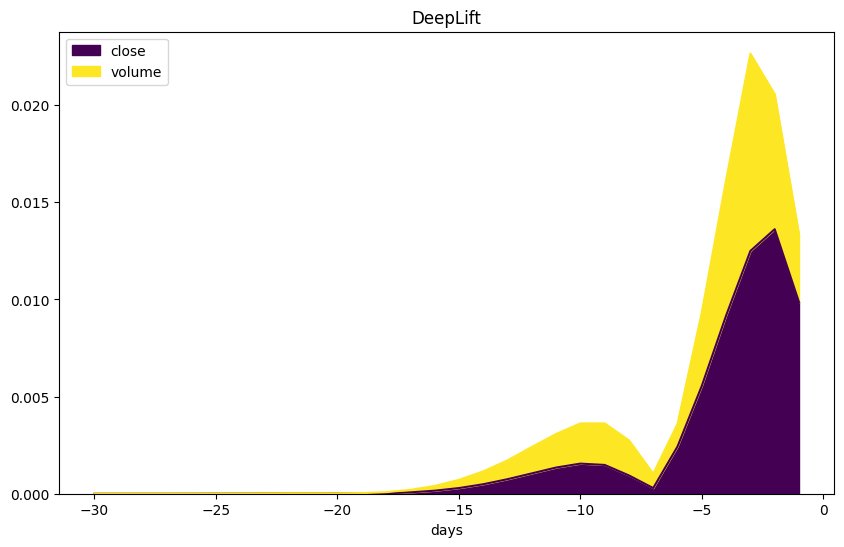

In [ ]:
generate_attr_area_plot(att, 'DeepLift')